In [1]:
!pip install imgaug                     

In [2]:
!pip install -U segmentation-models    

     |████████████████████████████████| 51kB 5.0MB/s 


In [3]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
GPU is available


In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
from keras.utils import generic_utils
import segmentation_models as sm

Segmentation Models: using `keras` framework.


* Setting up environment to connect kaggle and colab

In [6]:
os.environ['KAGGLE_USERNAME'] = "kanishkapandey"
os.environ['KAGGLE_KEY'] = "76240e9e3c518a7d0844f07ba6617476"

* kaggle dataset api

In [7]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:41<00:00, 19.0MB/s]
100% 1.03G/1.03G [00:41<00:00, 26.5MB/s]


In [8]:
os.listdir()

['.config', 'covid19-ct-scans.zip', 'sample_data']

In [9]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [10]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [11]:
raw_data.shape

(20, 4)

In [17]:
img_size = 512

In [12]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

In [13]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

In [14]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [15]:
cts = []
lungs = []

In [18]:
for i in range(0, 20):
    read_nii_demo(raw_data.loc[i,'lung_mask'], lungs)
    read_nii_demo(raw_data.loc[i,'ct_scan'], cts) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [19]:
print(len(cts), len(lungs))

2112 2112


In [20]:
new_cts = []
new_lungs = []

In [21]:
del lungs[1368:1372]
del cts[1368:1372]
del lungs[1924:1926]
del cts[1924:1926]

In [22]:
for img_no in range(len(lungs)):

    lung_img = lungs[img_no]
    lung_img[lung_img>0]=1
    cropped_lung, points1, points2 = cropper(lung_img, demo = 0)
    new_lungs.append(cropped_lung)

    cts_img = cts[img_no]
    cts_img = clahe_enhancer(cts_img, demo = 0)
    # img, points1, points2 = cropper(img, demo = 0)
    # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
    # all_points2.append((points2[0], points2[1], points2[2], points2[3]))
    a,b,c,d = points1[0], points1[1], points1[2], points1[3]
    e,f,g,h = points2[0], points2[1], points2[2], points2[3]
    img1 = cts_img[b:b+d, a:a+c]
    img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
    img2 = cts_img[f:f+h, e:e+g]
    img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
    cropped_cts = np.concatenate((img1, img2), axis=1)
    new_cts.append(cropped_cts)

In [23]:
print(len(new_cts), len(new_lungs))

2106 2106


(512, 512) (512, 512)


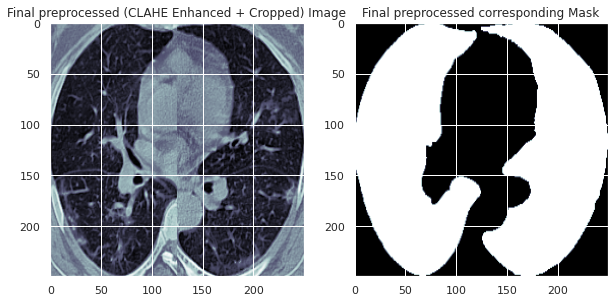

In [24]:
x = 100

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(new_cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(new_lungs[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, lungs[x].shape)

In [25]:
no_masks = []
for i in range(0, len(lungs)):
  if np.unique(lungs[i]).size == 1:
    no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

Number of complete black masks : 0


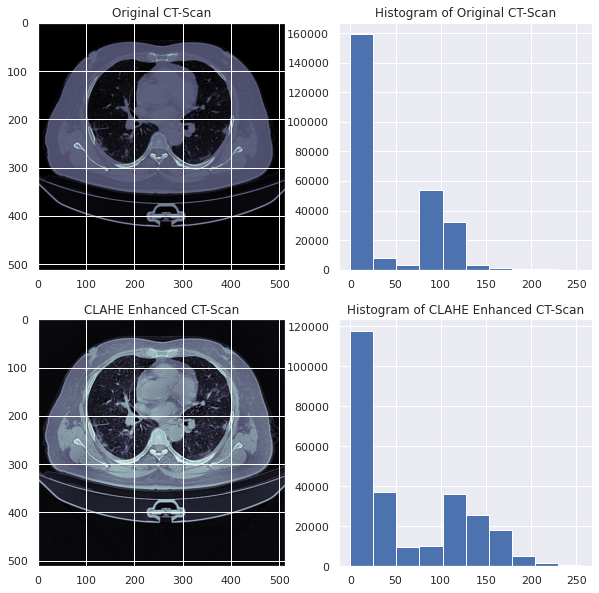

In [26]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[100], demo = 1)

* A demo for the cropped images, notice how the unwanted part including the diaphragm got cut

In [27]:
# fig = plt.figure()
# rcParams['figure.figsize'] = 35, 35

# cropped_image, points1, points2 = cropper(test_file[120], demo = 1)
# #print(ret)
# print(points1, points2)

In [28]:
# test_mask = []
# read_nii_demo(raw_data.loc[0,'infection_mask'], test_mask)
# test_mask = np.array(test_mask)
# test_mask = np.uint8(test_mask*255)
# rcParams['figure.figsize'] = 10,10
# plt.imshow(test_mask[120][20:155, 4:217], cmap = 'bone')
# test_mask[120][20:155, 4:217].shape

In [29]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 512.0 x 512.0


In [30]:
# 32*11 = 352

In [31]:
new_dim = 224

In [32]:
for i in range(0,len(new_cts)):
  new_cts[i] = cv2.resize(new_cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  new_lungs[i] = cv2.resize(new_lungs[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [33]:
# for i in range(0, len(cts)):
#   cts[i] = cv2.cvtColor(cts[i], cv2.COLOR_GRAY2RGB)
# for i in range(0, len(infections)):
#   infections[i] = cv2.cvtColor(infections[i], cv2.COLOR_GRAY2RGB)

In [34]:
new_cts = np.array(new_cts)
new_lungs = np.array(new_lungs)

In [35]:
# cts = cts.reshape( len(cts), new_dim, new_dim)
# infections = infections.reshape( len(infections), new_dim, new_dim)

In [36]:
new_cts = np.uint8(new_cts)
new_lungs = np.uint8(new_lungs)

In [37]:
# No Augmentation added this time

* Data augmentation pipeline

In [38]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [39]:
no_of_aug_imgs = 50
random_indices = np.random.randint(0, new_cts.shape[0], size=no_of_aug_imgs)
sample_new_cts = new_cts[random_indices]
sample_new_lungs = new_lungs[random_indices]

In [40]:
# sample_cts = np.floor(sample_cts)
# sample_inf = np.floor(sample_inf)
# sample_cts = np.uint64(sample_cts)
# sample_inf = np.uint64(sample_inf)

In [41]:
new_cts_aug, new_lungs_aug = seq(images=sample_new_cts, 
                              segmentation_maps=sample_new_lungs)

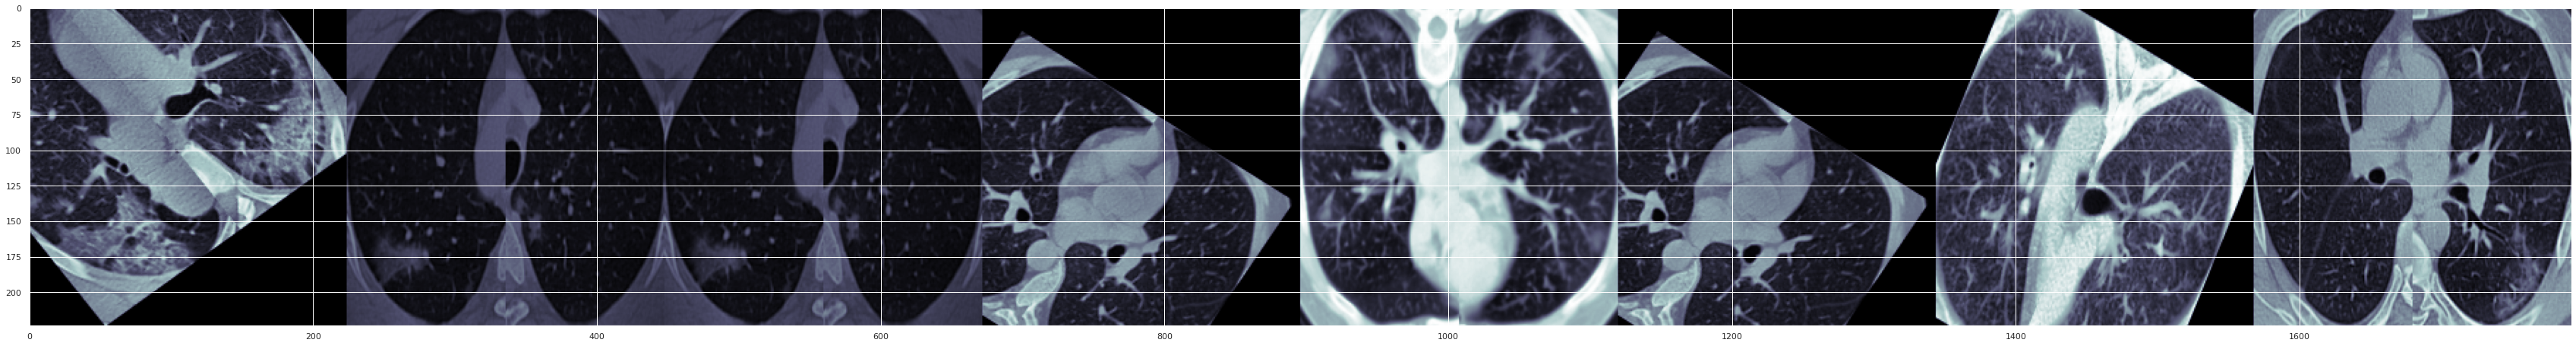

In [42]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = new_cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

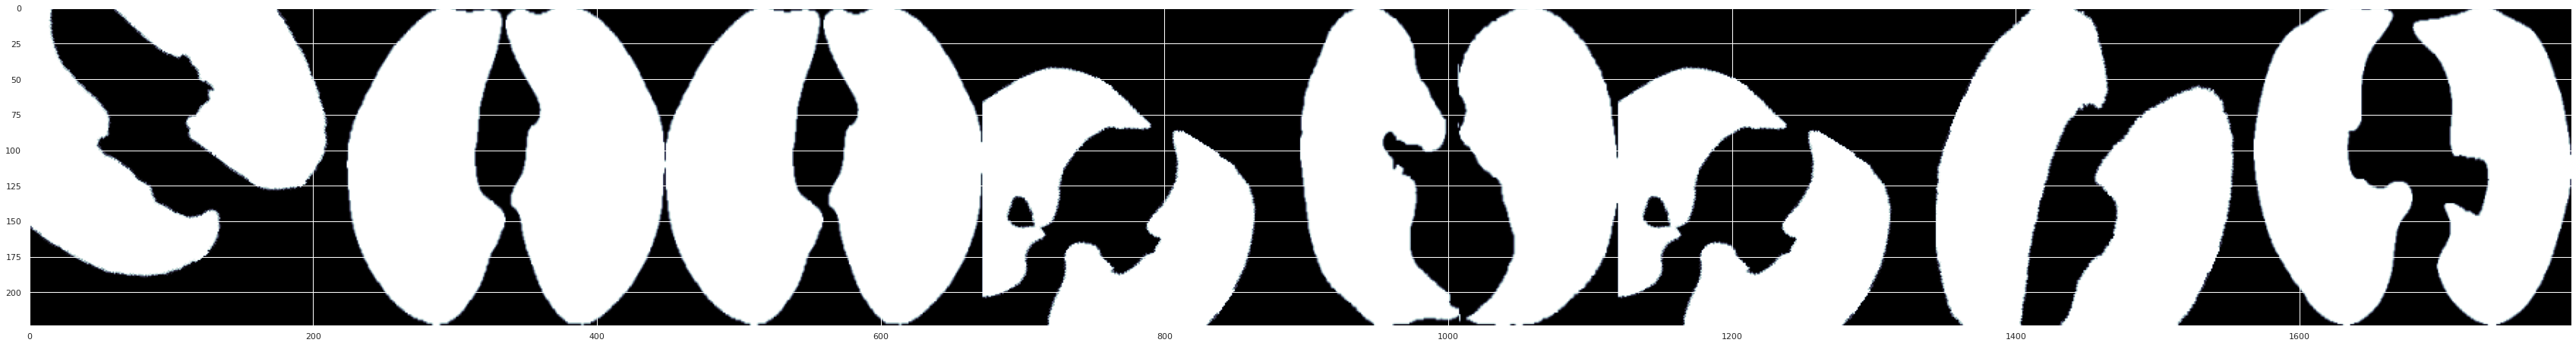

In [43]:
cells2 = new_lungs_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [44]:
print(new_cts_aug.shape, new_lungs_aug.shape)

(50, 224, 224) (50, 224, 224)


In [45]:
# cts = np.concatenate((cts, cts_aug), axis=0)
# infections = np.concatenate((infections, infections_aug), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
# print(cts.shape, infections.shape)

In [46]:
new_cts_aug = new_cts_aug/255
new_lungs_aug = new_lungs_aug/255
new_cts_aug = new_cts_aug.reshape(len(new_cts_aug), new_dim, new_dim, 1)
new_lungs_aug = new_lungs_aug.reshape(len(new_lungs_aug), new_dim, new_dim, 1)

* Normalizing images and masks from 0 to 1

In [47]:
joblib.dump(cts, 'cts_cropped_lungs_224.pkl')

['cts_cropped_lungs_224.pkl']

In [57]:
#files.download('cts_cropped_lungs_224.pkl')

In [58]:
#joblib.dump(infections, 'infections_cropped_lungs_224.pkl')

In [59]:
#files.download('infections_cropped_lungs_224.pkl')

In [60]:
# temp = joblib.load('infections_cropped_lungs_224.pkl')

In [54]:
new_cts = new_cts/255
new_lungs = new_lungs/255

In [55]:
new_cts = new_cts.reshape(len(new_cts), new_dim, new_dim, 1)
new_lungs = new_lungs.reshape(len(new_lungs), new_dim, new_dim, 1)

In [61]:
# cts_new = []
# # lungs_infections_new = []
# infections_new = []

In [62]:
# for i in range(0, 2112):
#   cts_new.append(np.array(cts[i]))
#   # lungs_infections_new.append(np.array(lungs_infections[i]))
#   infections_new.append(np.array(infections[i]))

In [63]:
# cts_new = np.array(cts_new)
# # lungs_infections_new = np.array(lungs_infections_new)
# infections_new = np.array(infections_new)

* Just overlaying infection masks over the corresponding CT scans

In [64]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0].reshape(img_size,img_size), cmap='bone')
    # plt.imshow(array_list[1].reshape(img_size, img_size), alpha=0.5, cmap=color_map)
    # plt.title('Lung and Infection Mask')

#     plt.subplot(1,4,4)
#     plt.imshow(array_list[0], cmap='bone')
#     plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
#     plt.title('Lung and Infection Mask')

    plt.show()

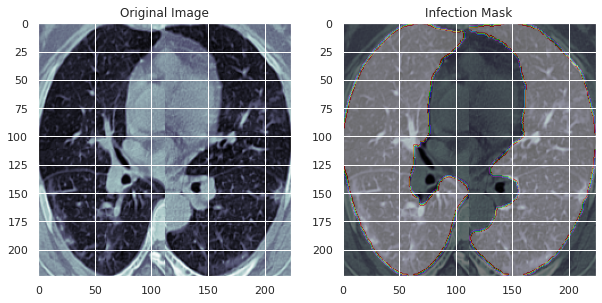

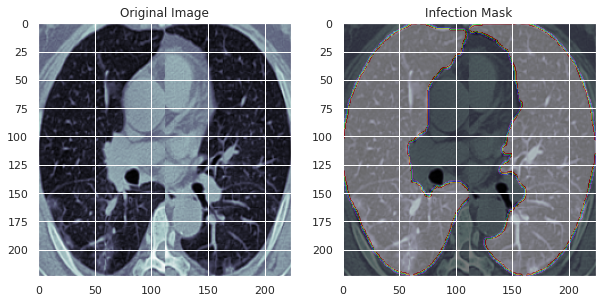

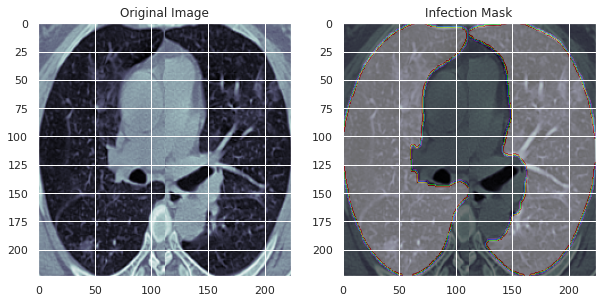

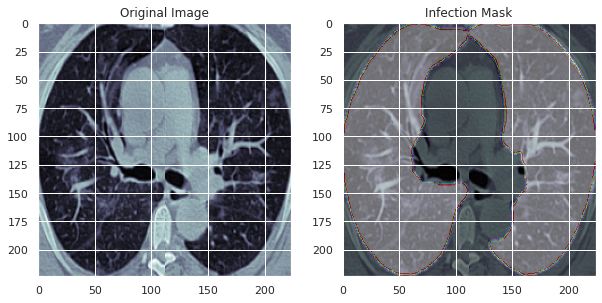

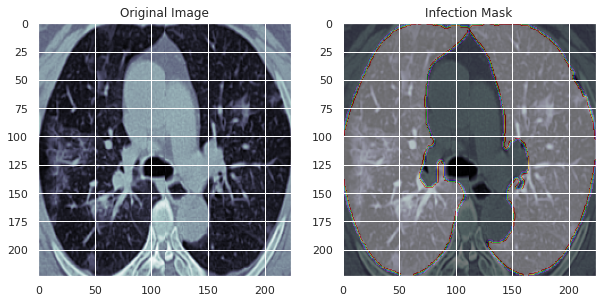

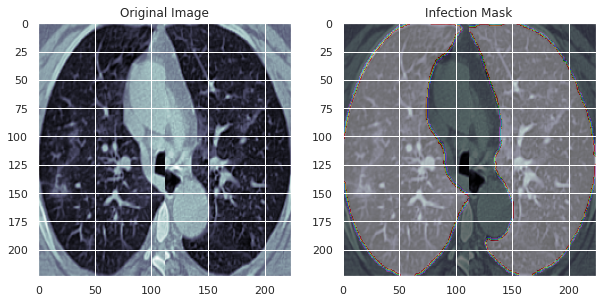

In [65]:
for index in [100,110,120,130,140,150]:
    plot_sample([new_cts[index], new_lungs[index]])

In [66]:
x_train, x_valid, y_train, y_valid = train_test_split(new_cts, new_lungs, test_size=0.3, random_state=42)

In [67]:
print(x_train.shape, x_valid.shape)

(1474, 224, 224, 1) (632, 224, 224, 1)


In [68]:
# x_train = np.concatenate((x_train, new_cts_aug), axis=0)
# y_train = np.concatenate((y_train, new_lungs_aug), axis = 0)
# print(x_train.shape, x_valid.shape)

* Loss functions and metrics

In [69]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

In [70]:
inputs = Input((new_dim, new_dim, 1))
# s = Lambda(lambda x: x / 255) (inputs)

# def mish(inputs):
#     return inputs * tf.math.tanh(tf.math.softplus(inputs))
    
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_1[0][0]                   
_______________________________________________________________________________________

* Some callbacks (model checkpointing with least validation loss, highest validation dice coefficient, learning rate reduction after some patience number of epochs)
* Also experimented with exponential decaying learning rate but found ReduceLROnPlateau a bit effective in this case.

In [71]:
# import math
# def step_decay(epoch):
#     initial_lrate = 0.0008
#     drop = 0.8
#     epochs_drop = 10
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     print('New learning rate', lrate)
#     return lrate

# lrate = LearningRateScheduler(step_decay)

In [72]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [73]:
cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.0005, eta_min=0.0001)

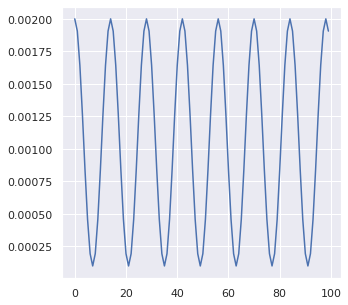

In [74]:
rcParams['figure.figsize'] = 5,5
T_max=7
eta_max=0.002
eta_min = 0.0001
lr=[]
for epoch in range(100):    
    lr.append(eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2)
lr = np.array(lr)
plt.plot(lr)

In [75]:
batch_size = 32
epochs = 80
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [76]:
model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

In [77]:
results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/80
47/47 [==============================] - ETA: 0s - loss: 0.1168 - dice_coeff: 0.9315
Epoch 00001: val_dice_coeff improved from -inf to 0.76846, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 1.11705, saving model to unet_covid_weights_val_loss.hdf5
47/47 [==============================] - 14s 295ms/step - loss: 0.1168 - dice_coeff: 0.9315 - val_loss: 1.1171 - val_dice_coeff: 0.7685
Epoch 2/80
46/47 [============================>.] - ETA: 0s - loss: 0.0628 - dice_coeff: 0.9643
Epoch 00002: val_dice_coeff did not improve from 0.76846

Epoch 00002: val_loss did not improve from 1.11705
47/47 [==============================] - 12s 257ms/step - loss: 0.0627 - dice_coeff: 0.9646 - val_loss: 1.2949 - val_dice_coeff: 0.3170
Epoch 3/80
46/47 [============================>.] - ETA: 0s - loss: 0.0556 - dice_coeff: 0.9673
Epoch 00003: val_dice_coeff did not improve from 0.76846

Epoch 00003: val_loss did not improve from 1.11705
47/47 [===

In [78]:
gc.collect()

1538

In [ ]:
model.load_weights(filepath_dice_coeff)

* Model saved in json format and its weight in .hdf5 format at local

In [ ]:
model.save_weights('unet_lung_segmentation_0.9813.h5')

In [ ]:
files.download('unet_lung_segmentation_0.9813.h5')

In [ ]:
model_json = model.to_json()
with open("unet_lung_segmentation_0.9813.json","w") as json_file:
     json_file.write(model_json)

files.download("unet_lung_segmentation_0.9813.json")

* Saved model results --> validation loss: 0.1504 and validation dice coefficient: 0.8780

* Though highest validation dice coefficient was 0.8789 but didn't saved it 
because of its high val loss of 0.1547

In [79]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

20/20 [==============================] - 1s 66ms/step - loss: 0.0369 - dice_coeff: 0.9813
test loss, test dice coefficient: [0.0369064062833786, 0.9813218116760254]


* I have specifically saved the least loss model rather than highest dice coefficient because, loss is generally a better predictor for overfitting, as you can see the validation dice coefficient still increased in the 79 th epoch when there was overfitting but loss was last saved on 51 st epoch, thus refrained more from overfitting.

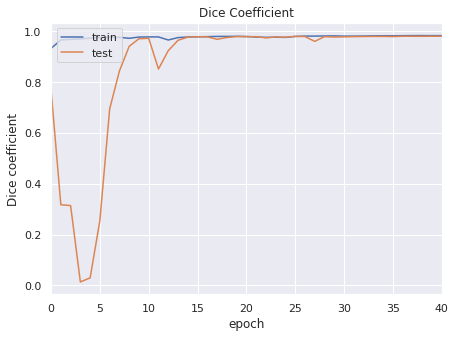

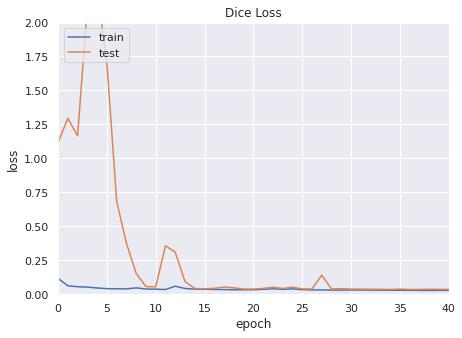

In [80]:
plt.rcParams["axes.grid"] = True
rcParams['figure.figsize'] = 7, 5
plt.xlim(0, 40)
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 2)
plt.xlim(0, 40)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* Some actual vs predicted samples to check the performance of the model visually. Notice, how overlapping they are with each other, thus justifying the high dice coefficient.

In [81]:
plt.rcParams["axes.grid"] = False

In [82]:
def compare_actual_and_predicted(image_no):
    temp = model.predict(new_cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(new_cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(new_lungs[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()
    
# plt.imshow(temp.reshape(img_size, img_size), cmap = 'bone')
# plt.imshow(infections_scaled[120].reshape(img_size, img_size), cmap ='summer')

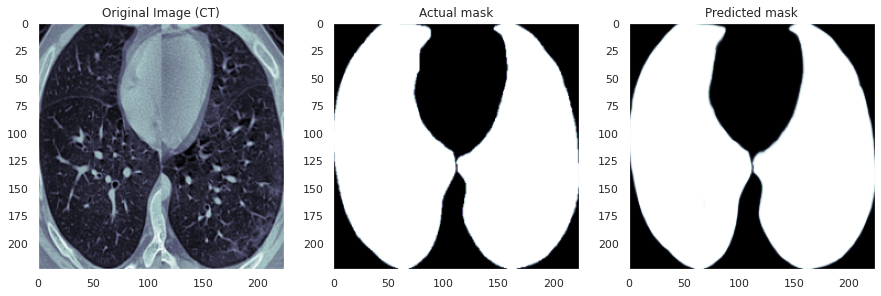

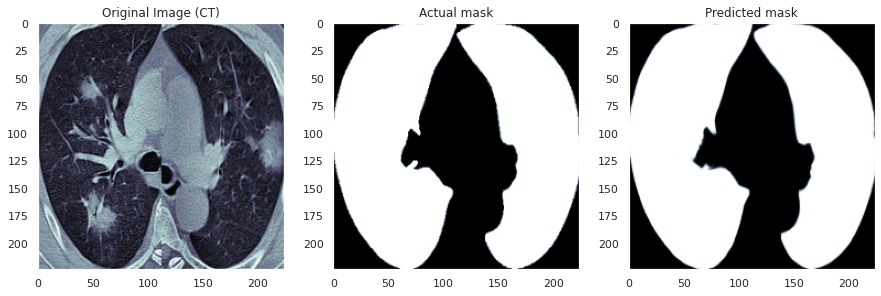

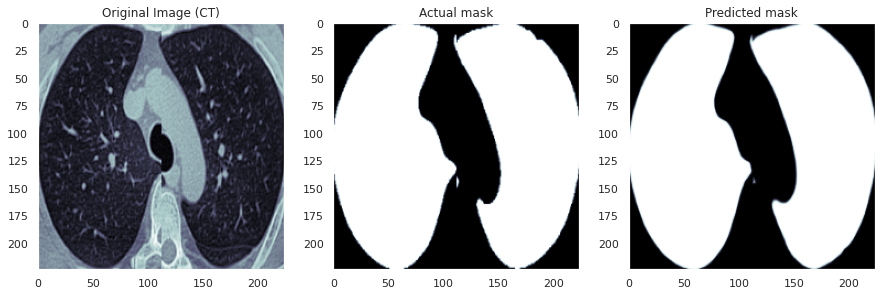

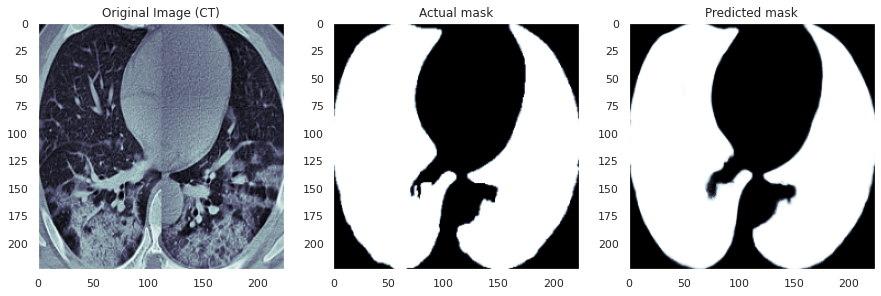

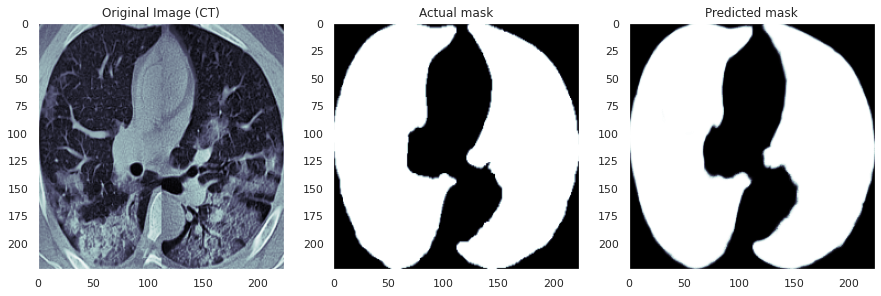

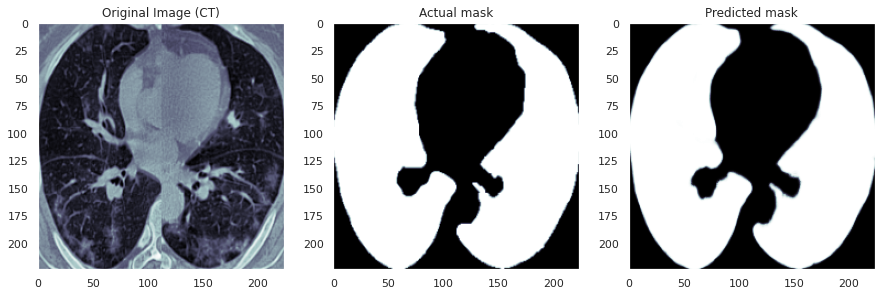

In [83]:
for i in [440,269,555, 355, 380, 90]:
    compare_actual_and_predicted(i)

In [84]:
gc.collect()

46210

# Some Significant Post-Processing

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# model.load_weights(filepath_dice_coeff)
model.load_weights('/content/drive/My Drive/cts and infections/unet_lung_segmentation_0.9813.h5')

In [85]:
the_range = np.arange(0.10,0.80, 0.05)

In [86]:
dices=[]
ious=[]

for t in the_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

20/20 [==============================] - 1s 67ms/step - loss: 0.0369 - f1-score: 0.9824 - iou_score: 0.9654


In [87]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.9811455607414246, 0.9825981259346008, 0.9834603071212769, 0.9839991331100464, 0.9843085408210754, 0.9844785928726196, 0.9845412969589233, 0.9845180511474609, 0.9844191670417786, 0.9842467308044434, 0.9839745759963989, 0.9835935831069946, 0.9830769300460815, 0.9823647737503052]
IOUS: [0.9629994630813599, 0.965802013874054, 0.967469334602356, 0.9685128331184387, 0.9691125750541687, 0.9694423675537109, 0.9695639610290527, 0.969519317150116, 0.9693279266357422, 0.9689933657646179, 0.9684662818908691, 0.9677282571792603, 0.9667289853096008, 0.9653528928756714]
Best Threshold: 0.40000000000000013
Best dice score: 0.9845412969589233
Best iou score: 0.9695639610290527


Best Threshold: 0.40000000000000013


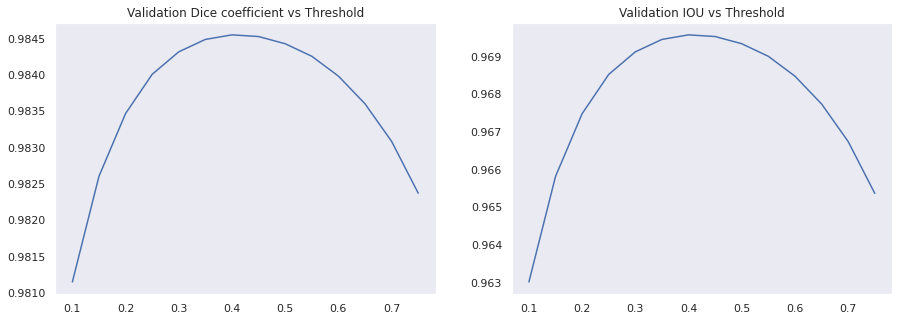

In [88]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [89]:
the_new_range = np.arange(0.43,0.53, 0.001)

In [90]:
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

20/20 [==============================] - 1s 67ms/step - loss: 0.0369 - f1-score: 0.9843 - iou_score: 0.9691


In [91]:
# print("We just checked for",len(the_new_range), "steps between 0.39 and 0.47")

In [92]:
print('NEW DICES:',new_dices)
print("NEW IOUS:",new_ious)
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

NEW DICES: [0.9845369458198547, 0.9845358729362488, 0.9845360517501831, 0.984533965587616, 0.9845342636108398, 0.9845333099365234, 0.9845326542854309, 0.984531581401825, 0.9845301508903503, 0.9845288395881653, 0.9845290184020996, 0.9845272898674011, 0.9845269322395325, 0.9845263361930847, 0.9845253229141235, 0.9845245480537415, 0.9845237731933594, 0.9845223426818848, 0.984520435333252, 0.9845191836357117, 0.9845180511474609, 0.9845172762870789, 0.9845163226127625, 0.9845148921012878, 0.9845135807991028, 0.984512209892273, 0.9845110774040222, 0.984509289264679, 0.9845080375671387, 0.9845055341720581, 0.9845035672187805, 0.9845017194747925, 0.984500527381897, 0.9844991564750671, 0.984498143196106, 0.9844962954521179, 0.9844948053359985, 0.9844932556152344, 0.9844911694526672, 0.984489917755127, 0.9844881296157837, 0.9844864010810852, 0.9844853281974792, 0.9844825863838196, 0.9844812154769897, 0.9844788312911987, 0.984477698802948, 0.9844760894775391, 0.9844738245010376, 0.984471201896667

Best Threshold: 0.43


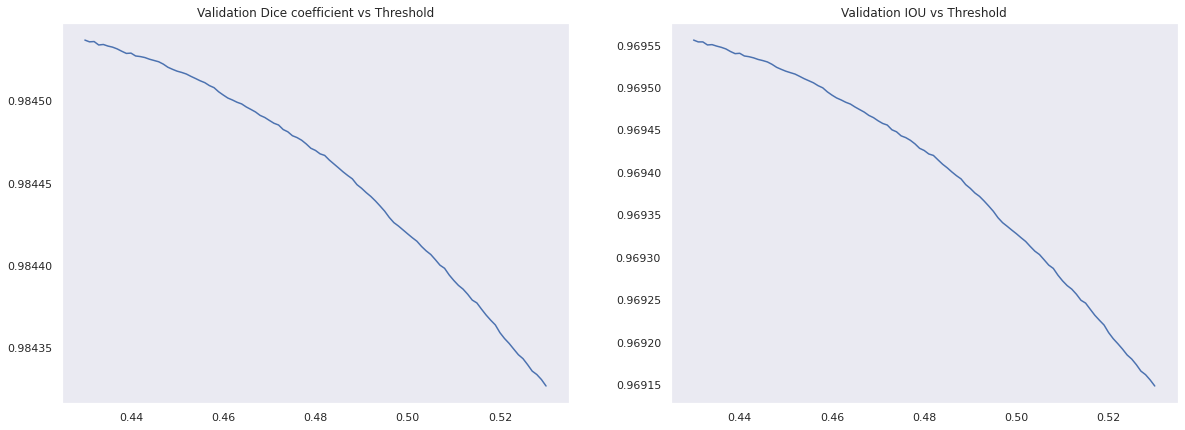

In [93]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [94]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [95]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])

20/20 [==============================] - 1s 67ms/step - loss: 0.0369 - precision: 0.9968 - recall: 0.9511


In [96]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

PRECISIONS: [0.5851823091506958, 0.9615135192871094, 0.9690477252006531, 0.9734729528427124, 0.9766356348991394, 0.9790902137756348, 0.9810217618942261, 0.9826416969299316, 0.9840437173843384, 0.9853144884109497, 0.9864779710769653, 0.9875971674919128, 0.9886662364006042, 0.9897146224975586, 0.9907716512680054, 0.9918417930603027, 0.9929564595222473, 0.9941109418869019, 0.9953585863113403, 0.9967633485794067]
RRECALLS: [1.0, 0.9954752922058105, 0.9935516119003296, 0.9918979406356812, 0.9903827905654907, 0.9889589548110962, 0.9876187443733215, 0.9863237142562866, 0.985040545463562, 0.9837242960929871, 0.9823705554008484, 0.9809203147888184, 0.9793287515640259, 0.9775490760803223, 0.9755024909973145, 0.9730690121650696, 0.9700787663459778, 0.9661720991134644, 0.960618793964386, 0.9511481523513794]
Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.9967633485794067
Best recall score: 1.0


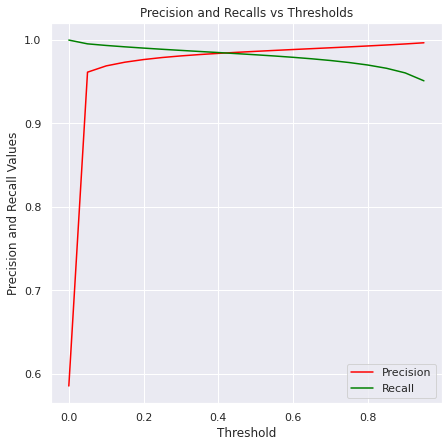

In [97]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])